In [1]:
import torch
from torch.utils.data import Dataset

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# !pip install wandb
import wandb
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
print(torch.__version__)

2.0.1+cu118


In [2]:
# importing weight and biases api 
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="transformer_timeseries",
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kirteshpatel98. Use `wandb login --relogin` to force relogin


In [3]:
'''
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/')


df=pd.read_csv('WTH.csv')
# df.drop('Unnamed: 0',axis=1,inplace=True)
df
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nimport os\nos.chdir('/content/drive/My Drive/')\n\n\ndf=pd.read_csv('WTH.csv')\n# df.drop('Unnamed: 0',axis=1,inplace=True)\ndf\n"

In [4]:
# importing data
df=pd.read_csv('ECL.csv',index_col=None)
# df.drop('Unnamed: 0',axis=1,inplace=True)
df.iloc[:,1:]

,MT_000,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,351.0,...,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0,2773.0
26300,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,327.0,...,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0,2755.0
26301,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,283.0,...,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0,2650.0
26302,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,292.0,...,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0,2719.0


In [5]:
# standard scalar normalisation 
scaler = StandardScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
df

,date,MT_000,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,...,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320
0,2012-01-01 00:00:00,-0.383963,-1.717456,4.415142,-0.166026,0.207430,1.205817,0.111579,-0.788632,0.132863,...,-1.152405,-1.078146,-0.824564,-0.814015,-1.096380,-1.254792,-0.362370,-1.295120,-1.215257,-2.123739
1,2012-01-01 01:00:00,-0.218172,-0.817354,6.000848,0.757970,1.311752,2.435814,0.111579,0.343236,0.669914,...,-1.045917,-0.969454,-0.721176,-0.825585,-0.930532,-1.184322,-0.120617,-0.159900,-0.949777,-0.906177
2,2012-01-01 02:00:00,-0.093828,-0.660815,6.000848,0.784183,1.024915,1.943014,0.111579,0.010587,0.657979,...,-1.036011,-0.999344,-0.711591,-0.880087,-0.935256,-1.188467,-0.228063,-0.130557,-1.080648,-1.034627
3,2012-01-01 03:00:00,-0.135276,-0.817354,6.000848,0.017463,0.178746,0.360445,-0.070958,-0.818873,-0.428057,...,-1.049219,-1.188197,-0.725969,-0.889679,-0.956411,-1.184322,-0.335508,-1.740771,-1.166648,-1.087093
4,2012-01-01 04:00:00,-0.052380,-0.856489,6.000848,-0.618194,-0.151116,-0.432843,-0.363016,-1.250883,-0.344516,...,-1.044266,-1.204501,-0.747879,-0.905816,-0.963291,-1.142869,-0.308647,-1.625232,-1.181605,-1.112421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2014-12-31 19:00:00,-0.508307,0.121883,-0.179340,2.645280,2.631202,3.345291,0.914738,1.682468,2.293001,...,-0.144486,0.575338,-0.232993,-0.022671,-0.540815,-0.110688,-0.819014,-0.722925,-1.290040,-1.018345
26300,2014-12-31 20:00:00,-0.508307,-0.386871,-0.179340,2.022730,2.444758,2.447833,0.768709,1.047413,1.839491,...,-0.576215,0.231598,-0.285714,-0.495377,-0.690335,-0.201885,-0.845875,-1.390485,-0.258035,-1.050910
26301,2014-12-31 21:00:00,-0.466859,-0.778219,-0.179340,1.373967,2.086212,2.111287,0.805216,0.243873,1.111489,...,-0.936127,0.197632,-0.316525,-0.527347,-1.003136,-0.201885,-0.899598,-0.733929,0.426230,-1.240871
26302,2014-12-31 22:00:00,-0.549754,-0.817354,-0.179340,1.347754,2.129238,2.027150,0.805216,-0.058534,0.872800,...,-1.022803,0.083505,-0.401427,-0.535873,-1.045034,-0.380133,-0.496677,0.658045,1.031973,-1.116039


In [6]:
# pytorch dataset class
class weather_data(torch.utils.data.Dataset):
    def __init__(self, df, mode="train", seq_len=336, pred_len=96,num_feat=321):
        super().__init__()
        self.num_feat=num_feat
        self.df = df.iloc[:,1:num_feat+1]
        # time_stamp = df.iloc[:,0]

        assert mode in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[mode]

        self.seq_len = seq_len
        self.pred_len = pred_len
        dataset_len=len(df)

        border1s = [0, int(round(0.7*dataset_len,0)) - self.seq_len, int(round(0.7*dataset_len,0)) + int(round(0.1*dataset_len,0)) - self.seq_len]
        border2s = [int(round(0.7*dataset_len,0)), int(round(0.7*dataset_len,0)) + int(round(0.1*dataset_len,0)), int(round(0.7*dataset_len,0)) + int(round(0.1*dataset_len,0)) + int(round(0.2*dataset_len,0))]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]




        self.df = self.df.to_numpy(dtype=np.float32)
        # time_stamp = time_stamp.to_numpy()

        self.data_x = self.df[border1: border2, :]
        self.data_y = self.df[border1: border2, :]

        # self.data_stamp = time_stamp[border1: border2]

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        return seq_x, seq_y


    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

In [7]:
from torch.utils.data import DataLoader

train_dataset = weather_data(df=df)
valid_dataset = weather_data(df=df,mode="val")
test_dataset = weather_data(df=df,mode="test")

print(len(train_dataset),len(valid_dataset),len(test_dataset))

17982 2535 5166


In [8]:
train_dataset[1][1].shape

(96, 321)

In [9]:
import os
current_directory = os.getcwd()
os.chdir(current_directory+r"\PatchTST\PatchTST_supervised")
from PatchTST.PatchTST_supervised.models.PatchTST import Model
os.chdir(current_directory)
Model

PatchTST.PatchTST_supervised.models.PatchTST.Model

In [10]:
# input configerations of model
class Configs:
    def __init__(self):
        self.enc_in = 321
        self.seq_len = 336
        self.pred_len = 96
        self.e_layers = 3
        self.n_heads = 4
        self.d_model = 16
        self.d_ff = 128
        self.dropout = 0.4
        self.fc_dropout = 0.
        self.head_dropout = 0.
        self.individual = True
        self.patch_len = 24
        self.stride = 6
        self.padding_patch = True
        self.revin = True
        self.affine = False
        self.subtract_last = False
        self.decomposition = False
        self.kernel_size = 25
        
my_configs = Configs()
model=Model(configs=my_configs)


In [11]:
'''
class Configs:
    def __init__(self):
        self.enc_in = 12
        self.seq_len = 336
        self.pred_len = 96
        self.e_layers = 3
        self.n_heads = 8
        self.d_model = 32*2
        self.d_ff = 1052
        self.dropout = 0.4
        self.fc_dropout = 0.
        self.head_dropout = 0.
        self.individual = True
        self.patch_len = 24
        self.stride = 8
        self.padding_patch = True
        self.revin = True
        self.affine = False
        self.subtract_last = False
        self.decomposition = False
        self.kernel_size = 25
        
my_configs = Configs()
model=Model(configs=my_configs)
'''

'\nclass Configs:\n    def __init__(self):\n        self.enc_in = 12\n        self.seq_len = 336\n        self.pred_len = 96\n        self.e_layers = 3\n        self.n_heads = 8\n        self.d_model = 32*2\n        self.d_ff = 1052\n        self.dropout = 0.4\n        self.fc_dropout = 0.\n        self.head_dropout = 0.\n        self.individual = True\n        self.patch_len = 24\n        self.stride = 8\n        self.padding_patch = True\n        self.revin = True\n        self.affine = False\n        self.subtract_last = False\n        self.decomposition = False\n        self.kernel_size = 25\n        \nmy_configs = Configs()\nmodel=Model(configs=my_configs)\n'

In [12]:
dat=torch.from_numpy(train_dataset[0][0])
dat=dat.unsqueeze(dim=0)
dat.shape
model(dat).shape

torch.Size([1, 96, 321])

In [14]:
# clearing gpu cache
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [15]:
# custom model class
class model_run:
    def __init__(self,model=model):
        self.patchtst_model = model
    # to display model architecture  
    def model_architecture(self):
        n=0
        for x in self.patchtst_model.state_dict():
            n=n+1
            print(x)
        print("layers= ",n)
    # loading datasets into batches
    def load_datasets(self,train_dataset=train_dataset,valid_dataset=valid_dataset,test_dataset=test_dataset):
        self.train_dataset=train_dataset
        self.valid_dataset=valid_dataset
        self.test_dataset=test_dataset


    # setting hyperparameters
    def model_hyperparameters(self,batch_size=16,lr=0.00005,epochs=100,cuda=True,Dataloader=DataLoader):
        self.batch_size = batch_size
        self.lr=lr # learning rate
        self.epochs=epochs # number of epochs

        self.train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=1, shuffle=False)
        self.valid_dataloader = DataLoader(self.valid_dataset, batch_size=batch_size, shuffle=True)

        # model to cuda gpu format
        if cuda:
            self.patchtst_model=self.patchtst_model.to("cuda")

        self.optimizer = torch.optim.Adam(self.patchtst_model.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss() # mean squared error loss
        self.loss_mae=torch.nn.L1Loss() # mean absolute error

    def model_execute(self,):
        self.load_datasets()
        self.model_hyperparameters()

        for epoch in range(self.epochs):
            iter_count = 0
            total_loss = 0
            train_steps=0
            total_train_mae_loss=0

            for train_x, train_y in tqdm(self.train_dataloader):
                train_x = train_x.to("cuda")
                train_y = train_y.to("cuda")
                
                self.i=train_x
                pred_y = self.patchtst_model(train_x)
                # print(train_x.shape)
                # print(train_y.shape)
                # print(pred_y.shape)
                train_mae_loss=self.loss_mae(pred_y, train_y)

                loss_t = self.loss(pred_y, train_y)
                self.optimizer.zero_grad()
                loss_t.backward()
                self.optimizer.step()
                total_loss += loss_t.item()
                total_train_mae_loss += train_mae_loss.item()
                iter_count += 1
                train_steps += 1

            valid_iter_count = 0
            valid_total_loss = 0
            valid_total_mae = 0
            with torch.no_grad():
                for valid_x, valid_y in self.valid_dataloader:
                    valid_x = valid_x.to("cuda")
                    valid_y = valid_y.to("cuda")
                    pred_y = self.patchtst_model(valid_x)
                    loss_v = self.loss(pred_y, valid_y)
                    valid_loss_mae=self.loss_mae(pred_y, valid_y)

                    valid_total_loss += loss_v.item()
                    valid_iter_count += 1

                    valid_total_mae+=valid_loss_mae.item()

                total_loss /= iter_count
                total_train_mae_loss /= iter_count

                valid_total_loss /= valid_iter_count
                valid_total_mae /= valid_iter_count
                wandb.log({"MSE Train": total_loss, "MSE Test": valid_total_loss,"MAE Train": total_train_mae_loss,"MAE Test": valid_total_mae})

                print("epoch: {} MSE loss: {:.4f} MSE valid loss: {:.4f}".format(epoch, total_loss, valid_total_loss))
                print("          MAE loss: {:.4f} MAE valid loss: {:.4f}".format(total_train_mae_loss, valid_total_mae))

    def save_model(self,name):
        torch.save(self.patchtst_model.state_dict(), name+'.pth')


    def test_plots(self,ind=3,df_columns=None,scaler=None,column=None):
        test_total_loss = 0
        test_total_loss_mae=0
        test_iter_count = 0
        test_pred_plot=[]
        test_y_plot=[]
        
        df_y_final=pd.DataFrame(columns=df_columns)
        df_pred_final=pd.DataFrame(columns=df_columns)
        
        for test_x, test_y in self.test_dataloader:
            test_x = test_x.to("cuda")
            test_y = test_y.to("cuda")
            test_pred=self.patchtst_model(test_x.to("cuda"))
            # print(test_pred.shape)
            # print(test_y.shape)
            loss_test=self.loss(test_pred, test_y)
            test_total_loss += loss_test.item()
            
            loss_test_mae=self.loss_mae(test_pred, test_y)
            test_total_loss_mae+=loss_test_mae.item()
            
            test_iter_count += 1
              
            df_y=pd.DataFrame(test_y[0].to("cpu").numpy(),columns=df_columns)
            df_pred=pd.DataFrame(test_pred[0].to("cpu").detach().numpy(),columns=df_columns)
            
            df_y_final = pd.concat([df_y_final, df_y], axis=0)
            df_pred_final = pd.concat([df_pred_final, df_pred], axis=0)
        df_pred_final=scaler.inverse_transform(df_pred_final)   
        df_y_final=scaler.inverse_transform(df_y_final)
        
        df_pred_final=pd.DataFrame(df_pred_final,columns=df_columns)
        df_y_final=pd.DataFrame(df_y_final,columns=df_columns)
        
        
        sns.lineplot(x=list(range(len(df_y_final)))[:96], y=df_y_final[column][:96], label="GroundTruth")
        sns.lineplot(x=list(range(len(df_pred_final)))[:96], y=df_pred_final[column][:96], label="Prediction")
        plt.legend(title='Type')
        plt.xlabel('Time Step')
        plt.title("Predicted vs Actual")
        plt.show()
        
        
        test_total_loss/= test_iter_count
        test_total_loss_mae/=test_iter_count
        print("MSE test loss: ",test_total_loss)
        print("MAE test loss: ",test_total_loss_mae)
         
'''
            # plotting
            
            for i,j in zip(test_pred[0],test_y[0]):
                pass
            # print(i[ind].item())
                test_pred_plot.append(i[ind].item())
            # print(j[ind].item())
                test_y_plot.append(j[ind].item())
        sns.lineplot(x=list(range(len(test_pred_plot)))[:96], y=test_pred_plot[:96], label="predicted")
        sns.lineplot(x=list(range(len(test_y_plot)))[:96], y=test_y_plot[:96], label="actual")
        plt.legend(title='Lines')
        plt.show()
        test_total_loss/= test_iter_count
        print("MSE test loss: ",test_total_loss)

        '''


'\n            # plotting\n            \n            for i,j in zip(test_pred[0],test_y[0]):\n                pass\n            # print(i[ind].item())\n                test_pred_plot.append(i[ind].item())\n            # print(j[ind].item())\n                test_y_plot.append(j[ind].item())\n        sns.lineplot(x=list(range(len(test_pred_plot)))[:96], y=test_pred_plot[:96], label="predicted")\n        sns.lineplot(x=list(range(len(test_y_plot)))[:96], y=test_y_plot[:96], label="actual")\n        plt.legend(title=\'Lines\')\n        plt.show()\n        test_total_loss/= test_iter_count\n        print("MSE test loss: ",test_total_loss)\n\n        '

In [16]:
x=model_run(model=model)

In [17]:
x.model_execute()

100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:42<00:00,  2.79it/s]


epoch: 0 MSE loss: 0.3346 MSE valid loss: 0.1996
          MAE loss: 0.4198 MAE valid loss: 0.3192


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:44<00:00,  2.78it/s]


epoch: 1 MSE loss: 0.2063 MSE valid loss: 0.1652
          MAE loss: 0.3214 MAE valid loss: 0.2819


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:44<00:00,  2.78it/s]


epoch: 2 MSE loss: 0.1826 MSE valid loss: 0.1535
          MAE loss: 0.2967 MAE valid loss: 0.2675


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:44<00:00,  2.78it/s]


epoch: 3 MSE loss: 0.1727 MSE valid loss: 0.1471
          MAE loss: 0.2854 MAE valid loss: 0.2593


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:44<00:00,  2.78it/s]


epoch: 4 MSE loss: 0.1671 MSE valid loss: 0.1434
          MAE loss: 0.2787 MAE valid loss: 0.2544


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:48<00:00,  2.75it/s]


epoch: 5 MSE loss: 0.1632 MSE valid loss: 0.1407
          MAE loss: 0.2741 MAE valid loss: 0.2506


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:50<00:00,  2.74it/s]


epoch: 6 MSE loss: 0.1603 MSE valid loss: 0.1383
          MAE loss: 0.2706 MAE valid loss: 0.2475


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:51<00:00,  2.73it/s]


epoch: 7 MSE loss: 0.1580 MSE valid loss: 0.1369
          MAE loss: 0.2679 MAE valid loss: 0.2454


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:50<00:00,  2.74it/s]


epoch: 8 MSE loss: 0.1562 MSE valid loss: 0.1358
          MAE loss: 0.2658 MAE valid loss: 0.2440


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:50<00:00,  2.74it/s]


epoch: 9 MSE loss: 0.1547 MSE valid loss: 0.1344
          MAE loss: 0.2640 MAE valid loss: 0.2423


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:53<00:00,  2.72it/s]


epoch: 10 MSE loss: 0.1534 MSE valid loss: 0.1338
          MAE loss: 0.2626 MAE valid loss: 0.2413


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:50<00:00,  2.74it/s]


epoch: 11 MSE loss: 0.1523 MSE valid loss: 0.1328
          MAE loss: 0.2613 MAE valid loss: 0.2400


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:51<00:00,  2.73it/s]


epoch: 12 MSE loss: 0.1513 MSE valid loss: 0.1321
          MAE loss: 0.2602 MAE valid loss: 0.2392


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:50<00:00,  2.74it/s]


epoch: 13 MSE loss: 0.1504 MSE valid loss: 0.1318
          MAE loss: 0.2592 MAE valid loss: 0.2385


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:51<00:00,  2.73it/s]


epoch: 14 MSE loss: 0.1495 MSE valid loss: 0.1311
          MAE loss: 0.2582 MAE valid loss: 0.2378


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:51<00:00,  2.73it/s]


epoch: 15 MSE loss: 0.1487 MSE valid loss: 0.1306
          MAE loss: 0.2574 MAE valid loss: 0.2371


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:51<00:00,  2.73it/s]


epoch: 16 MSE loss: 0.1479 MSE valid loss: 0.1301
          MAE loss: 0.2565 MAE valid loss: 0.2364


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:51<00:00,  2.73it/s]


epoch: 17 MSE loss: 0.1472 MSE valid loss: 0.1296
          MAE loss: 0.2557 MAE valid loss: 0.2357


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:46<00:00,  2.77it/s]


epoch: 18 MSE loss: 0.1465 MSE valid loss: 0.1293
          MAE loss: 0.2549 MAE valid loss: 0.2352


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:44<00:00,  2.78it/s]


epoch: 19 MSE loss: 0.1458 MSE valid loss: 0.1289
          MAE loss: 0.2541 MAE valid loss: 0.2346


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:44<00:00,  2.78it/s]


epoch: 20 MSE loss: 0.1452 MSE valid loss: 0.1285
          MAE loss: 0.2534 MAE valid loss: 0.2343


100%|██████████████████████████████████████████████████████████████████████████████| 1124/1124 [06:45<00:00,  2.77it/s]


epoch: 21 MSE loss: 0.1446 MSE valid loss: 0.1282
          MAE loss: 0.2528 MAE valid loss: 0.2337


  1%|▉                                                                               | 13/1124 [00:04<06:40,  2.77it/s]


KeyboardInterrupt: 

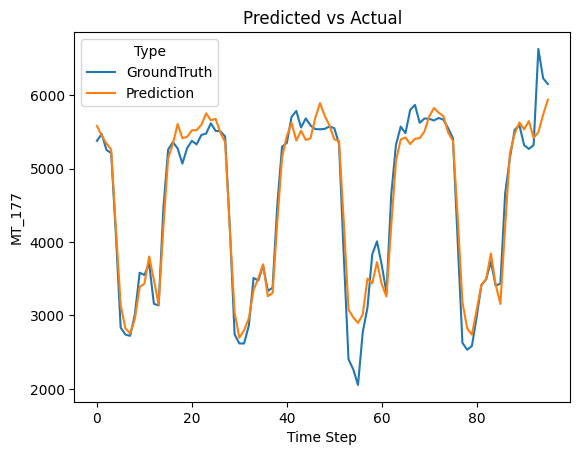

MSE test loss:  0.1531511667251956
MAE test loss:  0.25897171620915577


In [20]:
x.test_plots(df_columns=df.columns[1:],scaler=scaler,column='MT_177')

In [ ]:
'''
dat=torch.from_numpy(train_dataset[0][0])
dat=dat.unsqueeze(dim=0)
dat.shape
model(dat).shape
'''